In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from collections import defaultdict

In [232]:
import math
import os
import numpy as np
import random
import time

In [122]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

In [252]:
from PIL import Image

In [251]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [116]:
NB_CLASSES = 500
IMG_SIZE = (512, 512)
MAP_SIZE = (32, 32)
DATASET_PATH = '/local/DEEPLEARNING/oid/'
BATCH_SIZE = 16
SEED = 1

# overlaps for RPN
RPN_MIN_OVERLAP = 0.3
RPN_MAX_OVERLAP = 0.7

NUM_REGIONS = 256    # how many anchors we keep for one image

In [29]:
# config
RPN_STRIDE = 16
ANCHOR_SCALES = [64, 128, 256] 
ANCHOR_RATIOS = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

In [119]:
random.seed(SEED)

## definitions

In [234]:
def load_annotations(annotations_path):
        '''
        one annotation csv line is like:
        img_id,folder,class_id,xmin,ymin,xmax,ymax

        38a420b38cd3c350,train_3,92,0.325781,0.450781,0.447917,0.668750

        ---

        load annotations:
        - samples[img_id][multilabel] = list(one_hot)   # (N, nb_classes) list of variable size depending on the number of bounding boxes that are GT
        - samples[img_id][bboxes] = list(bbox)          # (N, 4) list of variable size of 4 int tuples representing x1, y1, x2, y2

        example:
        samples['5c015f7e9bbd728a']['multilabel'][0] = [0, 1, ....] (length 500)
        samples['5c015f7e9bbd728a']['bboxes'][0] = (x1, y1, x2, y2)
        '''

        samples = defaultdict(lambda: defaultdict(list))
        class_data = load_class_data()

        # multilabel annotations
        with open(annotations_path, 'r') as f_in:
            for line in f_in:
                parts = line.strip().split(',')
                img_id = parts[0]
                class_id = int(parts[2])
                ground_truth_cls = one_hotify_gt(class_id)

                samples[img_id]['multilabel'].append(ground_truth_cls)
                samples[img_id]['bboxes'].append((float(parts[3]), float(parts[4]), float(parts[5]), float(parts[6])))
                samples[img_id]['classes'].append((class_data[class_id]['id'], class_data[class_id]['name']))
                
                size = (parts[7], parts[8])
                
                if samples[img_id]['size'] == list(): # default 
                    samples[img_id]['size'] = size 
                else:
                    assert samples[img_id]['size'] == size    # it should always be the same

        return samples

In [230]:
def load_class_data():
    class_data = dict()
    class_data_path = os.path.join(DATASET_PATH, 'annotations', 'challenge-2018-classes.csv')
    
    with open(class_data_path, 'r') as f_in:
        for line in f_in:
            parts = line.strip().split(',')
            class_id = int(parts[0])
            class_name = parts[1]
            class_oid = parts[2]
            
            class_data[class_id] = {'id': class_id, 'name': class_name, 'oid': class_oid}
            
    return class_data

In [31]:
def one_hotify_gt(numeric_gt):
    return np.array([int(i == numeric_gt) for i in range(NB_CLASSES)])

## execution

### Loading data

In [235]:
annotations_file = os.path.join(DATASET_PATH, 'annotations', 'challenge-2018-train.csv')

t0 = time.time()
samples = load_annotations(annotations_file)
t1 = time.time()

total = t1-t0
print('loaded annotations in %s' % total)

loaded annotations in 2573.7738497257233


In [59]:
test = load_annotations(annotations_file)

('1024', '678')
('1024', '678')


RuntimeError: No active exception to reraise

In [62]:
len(samples)

1578819

In [63]:
sample_ids = sorted(samples.keys())

In [215]:
sample_ids.index('1cb71505057b99dc')

226838

In [64]:
nb_samples = len(sample_ids)

In [65]:
# del samples[1]

In [66]:
list_ints = list()
for sid in samples.keys():
    if isinstance(sid, int):
        list_ints.append(sid)

In [67]:
len(list_ints)

0

In [38]:
samples['38a420b38cd3c350']['bboxes']

[('0.325781', '0.447917', '0.450781', '0.668750'),
 ('0.279687', '0.339583', '0.344531', '0.501042'),
 ('0.307031', '0.240625', '0.401563', '0.398958'),
 ('0.373437', '0.492708', '0.447656', '0.657292'),
 ('0.496875', '0.221875', '0.600000', '0.425000'),
 ('0.073437', '0.323958', '0.244531', '0.735417'),
 ('0.121875', '0.508333', '0.283594', '0.831250'),
 ('0.132031', '0.493750', '0.392969', '0.769792'),
 ('0.399219', '0.321875', '0.675000', '0.469792'),
 ('0.378125', '0.509375', '0.445312', '0.582292'),
 ('0.314063', '0.401042', '0.340625', '0.439583'),
 ('0.364062', '0.281250', '0.388281', '0.328125'),
 ('0.403125', '0.555208', '0.430469', '0.585417'),
 ('0.568750', '0.278125', '0.592969', '0.326042'),
 ('0.094531', '0.942708', '0.146094', '0.998958'),
 ('0.128125', '0.528125', '0.271094', '0.640625'),
 ('0.153906', '0.619792', '0.247656', '0.747917'),
 ('0.591406', '0.320833', '0.672656', '0.397917'),
 ('0.648438', '0.354167', '0.796875', '0.864583'),
 ('0.440625', '0.187500', '0.59

#### IoU

In [39]:


def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def compute_iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)



#### Creating generator

In [325]:
def calc_rpn(img_data):
    '''
    getting the RPN ground truth for all anchors (9 anchors total)
    
    if the CNN output size is 56x56=3136, there are 3136x9=28224 potential anchors
    we select 256 of them, balanced between positive and negative anchors
    
    inputs: 
        - img_data: the dict containing information about the image for which the RPN ground truth is computed (= samples[img_id])

	Returns:
		y_rpn_cls: list(num_bboxes, y_is_box_valid + y_rpn_overlap)
			y_is_box_valid: 0 or 1 (0 means the box is invalid, 1 means the box is valid)
			y_rpn_overlap: 0 or 1 (0 means the box is not an object, 1 means the box is an object)
		y_rpn_regr: list(num_bboxes, 4*y_rpn_overlap + y_rpn_regr)
			y_rpn_regr: x1,y1,x2,y2 bunding boxes coordinates
    '''
    
    downscale = float(RPN_STRIDE) 
    anchor_sizes = ANCHOR_SCALES   # [64, 128, 256] because the input image is half the original size so we take half the original anchors
    anchor_ratios = ANCHOR_RATIOS  # 1:1, 1:2*sqrt(2), 2*sqrt(2):1
    num_anchors = len(anchor_sizes) * len(anchor_ratios) # 3x3=9
    
    original_width = img_data['size'][0]
    original_height = img_data['size'][1]
    print(original_width)
    print(original_height)
    print(img_data['size'])
    resized_width, resized_height = IMG_SIZE
    
    map_width, map_height = MAP_SIZE  # = output_width, output_height
    
    downscale_x = resized_width / map_width
    downscale_y = resized_height / map_height
    
    # initialise empty output batch
    y_rpn_overlap = np.zeros((map_height, map_width, num_anchors))      # one bool for each anchor. 1 means anchor overlaps with GT and 0 not
    y_is_box_valid = np.zeros((map_height, map_width, num_anchors))     # one bool for each anchor for validity (i.e. whether the box is clearly negative of clearly positive)
    y_rpn_regr = np.zeros((map_height, map_width, num_anchors * 4))     # regression coordinates for each anchor
    
    # ground truth bounding boxes for the image
    num_bboxes = len(img_data['bboxes'])

    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)             # will store how many anchor boxes match the ground truth bbox
    best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)    # keep track of which anchor is best for each gt box. anchor is described as (x, y, i_anchor_size, i_anchor_ratio). x and y are the coords in the cnn output feature map from which the anchor is
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)         # iou between best anchor box and gt box
    best_anchor_bbox_for_bbox = np.zeros((num_bboxes, 4)).astype(int)           # bounding box of the best anchor for the gt box
    best_anchor_var_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)     # variation
    
    # get the GT box coordinates, and resize to account for image resizing
    gt_boxes = np.zeros((num_bboxes, 4))    # xmin, ymin, xmax, ymax
    for i_bbox, bbox in enumerate(img_data['bboxes']):
        
        # get the GT box coordinates, and resize to account for image resizing
        # TODO: remove the float when data are re-loaded
        # gt_boxes[i_bbox, 0] = float(bbox[0]) * (resized_width / float(original_width))      # xmin
        # gt_boxes[i_bbox, 1] = float(bbox[1]) * (resized_height / float(original_height))    # ymin
        # gt_boxes[i_bbox, 2] = float(bbox[2]) * (resized_width / float(original_width))      # xmax
        # gt_boxes[i_bbox, 3] = float(bbox[3]) * (resized_height / float(original_height))    # ymax
        gt_boxes[i_bbox, 0] = float(bbox[0]) * resized_width      # xmin
        gt_boxes[i_bbox, 1] = float(bbox[1]) * resized_height     # ymin
        gt_boxes[i_bbox, 2] = float(bbox[2]) * resized_width      # xmax
        gt_boxes[i_bbox, 3] = float(bbox[3]) * resized_height     # ymax
        
    print('image has %s GT boxes' % len(img_data['bboxes']))
    # --------------- rpn ground truth -----------------
    
    # double loop to iterate on each anchor type (size + ratio) (9 total)
    for i_anchor_size in range(len(anchor_sizes)):
        for i_anchor_ratio in range(len(anchor_ratios)):
            anchor_width = anchor_sizes[i_anchor_size] * anchor_ratios[i_anchor_ratio][0]
            anchor_height = anchor_sizes[i_anchor_size] * anchor_ratios[i_anchor_ratio][1]
            
            # x-coordinates of the current anchor box
            for ix in range(map_width):                     
                x1_anc = downscale_x * (ix + 0.5) - anchor_width / 2
                x2_anc = downscale_x * (ix + 0.5) + anchor_width / 2 
                
                # ignore boxes that go across image boundaries                  
                if x1_anc < 0 or x2_anc > resized_width:
                    continue
                    
                # y-coordinates of the current anchor box
                for jy in range(map_height):
                    y1_anc = downscale_y * (jy + 0.5) - anchor_height / 2
                    y2_anc = downscale_y * (jy + 0.5) + anchor_height / 2
                    
                    # ignore boxes that go across image boundaries
                    if y1_anc < 0 or y2_anc > resized_height:
                        continue

                    # bbox_type indicates whether an anchor should be a target (default is negative)
                    anchor_box_type = 'neg'

                    # this is the best IOU for the (x,y) coord and the current anchor
                    # note that this is different from the best IOU for a GT bbox
                    # TODO: ???
                    best_iou_for_anchor = 0.0
                    best_regr_for_anchor = None
                    
                    # for each ground truth bbox 
                    for i_gt_box in range(num_bboxes):
                        # get IoU between current GT box and the current anchor box
                        curr_iou = compute_iou([gt_boxes[i_gt_box, 0], gt_boxes[i_gt_box, 1], gt_boxes[i_gt_box, 2], gt_boxes[i_gt_box, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
                        if curr_iou > 0.5:
                            print('gt box [%s %s %s %s], anchor [%s %s %s %s]' % (gt_boxes[i_gt_box, 0], gt_boxes[i_gt_box, 1], gt_boxes[i_gt_box, 2], gt_boxes[i_gt_box, 3], x1_anc, y1_anc, x2_anc, y2_anc))
                            print('iou for anchor [%s %s %s %s] and bbox %s : %s' % (i_anchor_size, i_anchor_ratio, ix, jy, i_gt_box, curr_iou))
                        
                        # calculate the regression targets if needed (best_iou_for_bbox is init to 0.0)
                        if curr_iou > best_iou_for_bbox[i_gt_box] or curr_iou > RPN_MAX_OVERLAP:
                            
                            # center points of GT box and anchor box
                            gt_center_x = (gt_boxes[i_gt_box, 0] + gt_boxes[i_gt_box, 2]) / 2.0
                            gt_center_y = (gt_boxes[i_gt_box, 1] + gt_boxes[i_gt_box, 3]) / 2.0
                            anc_center_x = (x1_anc + x2_anc) / 2.0
                            anc_center_y = (y1_anc + y2_anc) / 2.0
                            
                            anchor_width = x2_anc - x1_anc
                            anchor_heigth = y2_anc - y1_anc
                            
                            gt_width = gt_boxes[i_gt_box, 2] - gt_boxes[i_gt_box, 0]
                            gt_height = gt_boxes[i_gt_box, 3] - gt_boxes[i_gt_box, 1]
                            
                            # target variations to transform the anchor box into the gt box
                            # this is calculated in the image reference (not the map)
                            target_dx = (gt_center_x - anc_center_x) / anchor_width
                            target_dy = (gt_center_y - anc_center_y) / anchor_heigth
                            target_dw = np.log(gt_width / anchor_width)
                            target_dh = np.log(gt_height / anchor_height)
                        
                        # keep track of which anchor box was best for current GT box
                        if curr_iou > best_iou_for_bbox[i_gt_box]:
                            best_iou_for_bbox[i_gt_box] = curr_iou
                            best_anchor_for_bbox[i_gt_box] = [ix, jy, i_anchor_size, i_anchor_ratio]
                            best_anchor_bbox_for_bbox[i_gt_box,:] = [x1_anc, y1_anc, x2_anc, y2_anc]
                            best_anchor_var_for_bbox[i_gt_box,:] = [target_dx, target_dy, target_dw, target_dh]
                            
                        # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
                        if curr_iou > RPN_MAX_OVERLAP:
                            print('found positive anchor for gt box %s' % i_gt_box)
                            anchor_box_type = 'pos'
                            num_anchors_for_bbox[i_gt_box] += 1
                            # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
                            if curr_iou > best_iou_for_anchor:
                                best_iou_for_anchor = curr_iou
                                best_regr_for_anchor = (target_dx, target_dy, target_dw, target_dh)
                                
                        # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
                        if RPN_MIN_OVERLAP < curr_iou < RPN_MAX_OVERLAP:
                            # gray zone between neg and pos
                            if anchor_box_type == 'neg':
                                anchor_box_type = 'neutral'
                            
                    # turn on or off outputs depending on IOUs
                    anchor_index = i_anchor_ratio + len(anchor_ratios) * i_anchor_size   # 0: 64, 1x1; 1: 64, 1x2V2; 2: 64, 2V2x1; 3: 128, 1x1, etc til 8 (= 9 anchors)
                    if anchor_box_type == 'neg':
                        y_is_box_valid[ix, jy, anchor_index] = 1
                        y_rpn_overlap[ix, jy, anchor_index] = 0
                    elif anchor_box_type == 'neutral':
                        y_is_box_valid[ix, jy, anchor_index] = 0
                        y_rpn_overlap[ix, jy, anchor_index] = 0
                    elif anchor_box_type == 'pos':
                        y_is_box_valid[ix, jy, anchor_index] = 1
                        y_rpn_overlap[ix, jy, anchor_index] = 1
                        start = 4 * anchor_index
                        y_rpn_regr[ix, jy, start:start+4] = best_regr_for_anchor
                        
    # find a ok-ish anchor for ground truth that don't have good anchors
    print(num_anchors_for_bbox)
    for i_gt, nb_anchors in enumerate(num_anchors_for_bbox):
        print('we found %s anchors for %s' % (nb_anchors, i_gt))
        if nb_anchors == 0:
            print('we didnt find any anchor for gt %s' % i_gt)
            # we didn't find any box with iou > 0 with GT...
            if best_anchor_for_bbox[i_gt, 0] == -1:
                print('hopeless for gt %s' % i_gt)
                continue
                
            best_anchor_mapx, best_anchor_mapy, best_anchor_size_i, best_anchor_ratio_i = best_anchor_for_bbox[i_gt]
            anchor_index = best_anchor_ratio_i + len(anchor_ratios) * best_anchor_size_i
            
            y_is_box_valid[best_anchor_mapx, best_anchor_mapy, anchor_index] = 1
            y_rpn_overlap[best_anchor_mapx, best_anchor_mapy, anchor_index] = 1
            start = 4 * anchor_index
            y_rpn_regr[best_anchor_mapx, best_anchor_mapy, start:start+4] = best_anchor_var_for_bbox[i_gt, :]
            
    # for outputs change dims to (anchor index (0-8), anchor_mapx, anchor_mapy) and add first dimension
    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)
    
    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)
    
    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)
    
    # valid and overlap = positive, valid and not overlap = negative
    pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
    neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))
    
    assert len(pos_locs[0]) == len(pos_locs[1]) == len(pos_locs[2])
    nb_pos = len(pos_locs[0])
    nb_neg = len(neg_locs[0])
    print('found %s positives and %s negatives' % (nb_pos, nb_neg))
    
    # one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
    # regions. We also limit it to 256 regions.
    num_regions = NUM_REGIONS

    # in case we have more than half the budget of positive anchors we invalidate some of them
    if nb_pos > num_regions / 2:
        val_locs = random.sample(range(nb_pos), nb_pos - num_regions/2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        nb_pos = num_regions / 2

    # invalidate excess negative examples so we have the same number of negatives and positives (max NUM_REGIONS for both)
    if nb_neg + nb_pos > num_regions:
        val_locs = random.sample(range(nb_neg), nb_neg - nb_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0
        
    print('shape y_is_box_valid %s, nonzero %s' % (str(y_is_box_valid.shape), np.count_nonzero(y_is_box_valid)))
    print('shape y_rpn_overlap %s, nonzero %s' % (str(y_rpn_overlap.shape), np.count_nonzero(y_rpn_overlap)))
    print('shape y_rpn_regr %s' % str(y_rpn_regr.shape))
    
    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
    y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

    return np.copy(y_rpn_cls), np.copy(y_rpn_regr), nb_pos
                            

In [314]:
# equivalent get_anchor_gt

In [315]:
def get_data_dict(samples, sample_ids, sample_idxs):
    '''
    Creation of the actual batch
    '''
    output = {}
    sample_ids = [sample_ids[i] for i in sample_idxs]

    img_batch = []
    cls_batch = []
    regr_batch = []

    img_data_batch = []
    ids_batch = []

    for img_id in sample_ids:
        img_data = dict()

        img_path = os.path.join(DATASET_PATH, 'images', 'train', 'train_%s' % img_id[0], '%s.jpg' % img_id)
        img = image.load_img(img_path, grayscale=False, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
        img_arr = image.img_to_array(img, data_format='channels_last')
        
        img_batch.append(img_arr)
        
        y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(samples[img_id])
        print("shape rpn cls %s" % str(y_rpn_cls.shape))
        print("shape rpn regr %s" % str(y_rpn_regr.shape))
        print('num pos %s' % num_pos)
        
        # y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling
        y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))
        y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
        
        cls_batch.append(y_rpn_cls)
        regr_batch.append(y_rpn_regr)
        ids_batch.append(img_id)
        
        # TODO: data augmentation
        
        img_data['num_pos'] = num_pos
        img_data['original_size'] = (samples[img_id]['size'][0], samples[img_id]['size'][1])
        img_data['bboxes'] = samples[img_id]['bboxes']
        img_data['classes'] = samples[img_id]['classes']

        img_data_batch.append(img_data)

    img_batch = np.reshape(img_batch, (-1, IMG_SIZE[0], IMG_SIZE[1], 3))  # TODO: figure out why this line is necessary
    img_batch = preprocess_input(img_batch, data_format='channels_last')

    ids_batch = np.reshape(np.array(ids_batch), (-1, 1))

    output['image'] = img_batch
    output['rpn_cls'] = cls_batch
    output['rpn_regr'] = regr_batch
    output['img_data'] = img_data_batch
    output['image_id'] = ids_batch

    return output

In [316]:
# get sample idx for the batch
def get_batch_indexes(batch_idx):

    batch_idxs = list()
    for i in range(BATCH_SIZE):
        sample_idx = batch_idx * BATCH_SIZE + i
        if sample_idx >= nb_samples:
            sample_idx -= nb_samples
        batch_idxs.append(sample_idx)
    return batch_idxs

In [317]:
batch_idxs = get_batch_indexes(4)
print(batch_idxs)

[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


In [318]:
batch_idxs = [226838]

In [326]:
batch = get_data_dict(samples, sample_ids, batch_idxs)

1024
768
('1024', '768')
image has 4 GT boxes
gt box [92.8 255.573504 139.52 310.613504], anchor [72.0 248.0 136.0 312.0]
iou for anchor [0 0 6 17] and bbox 0 : 0.5542824404322323
gt box [92.8 255.573504 139.52 310.613504], anchor [88.0 248.0 152.0 312.0]
iou for anchor [0 0 7 17] and bbox 0 : 0.6277999998467284
gt box [332.16 251.306496 378.24 310.613504], anchor [312.0 248.0 376.0 312.0]
iou for anchor [0 0 21 17] and bbox 2 : 0.61482924329103
gt box [332.16 251.306496 378.24 310.613504], anchor [328.0 248.0 392.0 312.0]
iou for anchor [0 0 22 17] and bbox 2 : 0.6672038398371078
gt box [92.8 255.573504 139.52 310.613504], anchor [97.37258300203048 218.74516600406096 142.62741699796953 309.25483399593907]
iou for anchor [0 1 7 16] and bbox 0 : 0.5136346257130668
gt box [92.8 255.573504 139.52 310.613504], anchor [97.37258300203048 234.74516600406096 142.62741699796953 325.25483399593907]
iou for anchor [0 1 7 17] and bbox 0 : 0.5335711266087212
gt box [92.8 255.573504 139.52 310.61350

In [243]:
print(batch.keys())

dict_keys(['image', 'rpn_cls', 'rpn_regr', 'img_data', 'image_id'])


## Viz

In [320]:
i_img = 0    # image index in the batch

In [321]:
print(batch['img_data'][i_img])

{'num_pos': 4, 'original_size': ('1024', '768'), 'bboxes': [(0.18125, 0.499167, 0.2725, 0.606667), (0.07875, 0.380833, 0.763125, 0.599167), (0.64875, 0.490833, 0.73875, 0.606667), (0.69125, 0.465, 0.725, 0.480833)], 'classes': [(371, 'Wheel'), (63, 'Car'), (371, 'Wheel'), (371, 'Wheel')]}


In [322]:
print('Original image: height=%s width=%s' % (batch['img_data'][i_img]['original_size'][0], batch['img_data'][i_img]['original_size'][0]))
#print('Resized image:  height=%d width=%d C.im_size=%d'%(X.shape[1], X.shape[2], C.im_size))
print('Feature map size: height=%d width=%d C.rpn_stride=%d'%(batch['rpn_cls'][i_img].shape[1], batch['rpn_cls'][i_img].shape[1], RPN_STRIDE))
print(batch['image'].shape)
print('Shape of y_rpn_cls {}'.format(batch['rpn_cls'][i_img].shape))
print('Shape of y_rpn_regr {}'.format(batch['rpn_regr'][i_img].shape))
print(batch['img_data'])

print('Number of positive anchors for image %s: %d' % (i_img, batch['img_data'][i_img]['num_pos']))

print('\n')
cls = batch['rpn_cls'][i_img][0]
pos_cls = np.where(cls==1)
print('pos_cls: %s' % str(pos_cls))
regr = batch['rpn_regr'][i_img][0]
pos_regr = np.where(regr==1)
print('pos_regr: %s' % str(pos_regr))
print('y_rpn_cls for possible pos anchor: {}'.format(cls[pos_cls[0][0],pos_cls[1][0],:]))
print('y_rpn_regr for positive anchor: {}'.format(regr[pos_regr[0][0],pos_regr[1][0],:]))

Original image: height=1024 width=1024
Feature map size: height=32 width=32 C.rpn_stride=16
(1, 512, 512, 3)
Shape of y_rpn_cls (1, 32, 32, 18)
Shape of y_rpn_regr (1, 32, 32, 72)
[{'num_pos': 4, 'original_size': ('1024', '768'), 'bboxes': [(0.18125, 0.499167, 0.2725, 0.606667), (0.07875, 0.380833, 0.763125, 0.599167), (0.64875, 0.490833, 0.73875, 0.606667), (0.69125, 0.465, 0.725, 0.480833)], 'classes': [(371, 'Wheel'), (63, 'Car'), (371, 'Wheel'), (371, 'Wheel')]}]
Number of positive anchors for image 0: 4


pos_cls: (array([ 7,  7,  8, 11, 13, 13, 21, 22, 22, 24, 24, 27]), array([17, 17, 10, 24, 14, 14,  6, 17, 17, 15, 15,  9]), array([ 0,  9,  6,  2,  8, 17,  1,  0,  9,  2, 11,  0]))
pos_regr: (array([ 7,  7,  7,  7, 13, 13, 13, 13, 22, 22, 22, 22, 24, 24, 24, 24]), array([17, 17, 17, 17, 14, 14, 14, 14, 17, 17, 17, 17, 15, 15, 15, 15]), array([ 0,  1,  2,  3, 32, 33, 34, 35,  0,  1,  2,  3,  8,  9, 10, 11]))
y_rpn_cls for possible pos anchor: [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


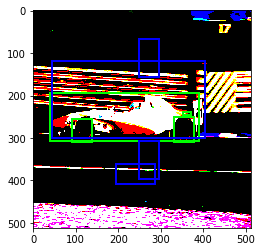

In [324]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(batch['image'][0])
im_width = batch['image'].shape[1]
im_height = batch['image'].shape[2]

gt_color = (0, 1, 0)
anc_color = (0, 0, 1)

# Create a Rectangle patch for each GT
for i_gt, gt_box in enumerate(batch['img_data'][i_img]['bboxes']):
    gt_x1, gt_x2 = gt_box[0] * im_width, gt_box[2] * im_width
    gt_y1, gt_y2 = gt_box[1] * im_height, gt_box[3] * im_height
    gt_x1, gt_y1, gt_x2, gt_y2 = int(gt_x1), int(gt_y1), int(gt_x2), int(gt_y2)

    gt_width = gt_x2 - gt_x1
    gt_height = gt_y2 - gt_y1

    rect = patches.Rectangle((gt_x1, gt_y1), gt_width, gt_height, linewidth=2, edgecolor=gt_color, facecolor='none')  # bottom left corner
    ax.add_patch(rect)

# Create rectangles for positive anchors
for i_anc in range(batch['img_data'][i_img]['num_pos']):
    # color = (100+i*(155/4), 0, 100+i*(155/4))
    
    idx = pos_regr[2][i_anc*4]/4
    anchor_size = ANCHOR_SCALES[int(idx/3)]
    anchor_ratio = ANCHOR_RATIOS[2-int((idx+1)%3)]
    
    center = (pos_regr[1][i_anc*4]*RPN_STRIDE, pos_regr[0][i_anc*4]*RPN_STRIDE)
    
    anc_w, anc_h = anchor_size*anchor_ratio[0], anchor_size*anchor_ratio[1]
    
    anc_x1 = center[0]-int(anc_w/2)
    anc_y1 = center[1]-int(anc_h/2)
    
    rect = patches.Rectangle((anc_x1, anc_y1), anc_w, anc_h, linewidth=2, edgecolor=anc_color, facecolor='none')  # bottom left corner
    ax.add_patch(rect)
    

plt.show()

In [ ]:
'''
Original image: height=768 width=1024
Resized image:  height=300 width=400 C.im_size=300
Feature map size: height=18 width=25 C.rpn_stride=16
(1, 300, 400, 3)
2 includes 'y_rpn_cls' and 'y_rpn_regr'
Shape of y_rpn_cls (1, 18, 25, 18)
Shape of y_rpn_regr (1, 18, 25, 72)
image_data : {'filepath': 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train/1cb71505057b99dc.jpg', 'width': 1024, 'height': 768, 'bboxes': [{'class': 'Car', 'x1': 80, 'x2': 781, 'y1': 292, 'y2': 460}]}
Number of positive anchors for this image: 1

pos_cls (array([ 9,  9, 15]), array([12, 12, 16]), array([ 5, 14,  5]))
pos_regr (array([9, 9, 9, 9]), array([12, 12, 12, 12]), array([20, 21, 22, 23]))
y_rpn_cls for possible pos anchor: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
y_rpn_regr for positive anchor: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          1.          1.          1.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.7034815  -0.22649515  1.65558708 -1.28599977
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
'''

In [302]:
def test_anchor(gt_coords, anc_coords):
    img = np.zeros([512,512,3],dtype=np.uint8)
    img.fill(255) # or img[:] = 255
    
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)
    im_width = img.shape[1]
    im_height =  img.shape[2]
    
    gt_width = gt_coords[2] - gt_coords[0]
    gt_height = gt_coords[3] - gt_coords[1]
    
    rect_gt = patches.Rectangle((gt_coords[0], gt_coords[1]), gt_width, gt_height, linewidth=2, edgecolor=gt_color, facecolor='none')
    ax.add_patch(rect_gt)
    
    anc_width = anc_coords[2] - anc_coords[0]
    anc_height = anc_coords[3] - anc_coords[1]
    
    rect_anc = patches.Rectangle((anc_coords[0], anc_coords[1]), anc_width, anc_height, linewidth=2, edgecolor=anc_color, facecolor='none')
    ax.add_patch(rect_anc)
    
    plt.show()

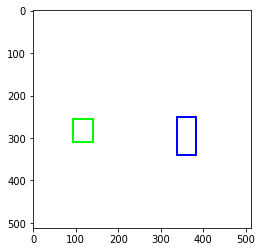

In [328]:
test_anchor([92.8, 255.573504, 139.52, 310.613504], [337.37258300203047, 250.74516600406096, 382.62741699796953, 341.25483399593907])

In [260]:
a = (155, 0, 255)
a /= 255
print(a)

TypeError: unsupported operand type(s) for /=: 'tuple' and 'int'